# Required Libraries

In [869]:
# install.packages("factoextra")

In [870]:
# libraries
library("readxl")
options(warn = 0)
library(dplyr)
library(ggplot2)
library(caTools)
library(caret)
library(GGally)
library(janitor)
library(corrplot)
library(tidyverse)
library(hrbrthemes)
library(viridis)
library(NbClust)
library(factoextra)

# Loading Dataset 

In [951]:
df <- read_excel("data/Whitewine_v2.xlsx")
#add index column to data frame
df$index <- 1:nrow(df)
head(df)

fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,index
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
8.1,0.27,0.41,1.45,0.033,11,63,0.9908,2.99,0.56,12.0,5,1
8.6,0.23,0.40,4.20,0.035,17,109,0.9947,3.14,0.53,9.7,5,2
7.9,0.18,0.37,1.20,0.040,16,75,0.9920,3.18,0.63,10.8,5,3
8.3,0.42,0.62,19.25,0.040,41,172,1.0002,2.98,0.67,9.7,5,4
6.5,0.31,0.14,7.50,0.044,34,133,0.9955,3.22,0.50,9.5,5,5
7.6,0.67,0.14,1.50,0.074,25,168,0.9937,3.05,0.51,9.3,5,6


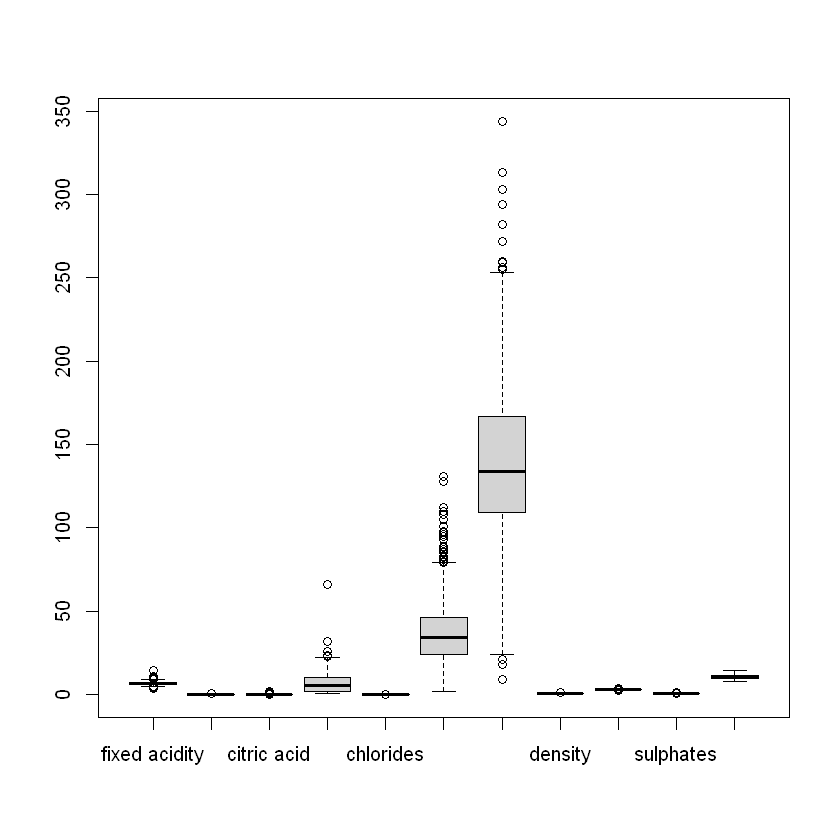

In [952]:
boxplot(df[1:11])

In [872]:
# format columns
df <- janitor::clean_names(df)

# EDA 

Getting some idea about the dataset

In [873]:
summary(df)

 fixed_acidity    volatile_acidity  citric_acid     residual_sugar  
 Min.   : 3.800   Min.   :0.0800   Min.   :0.0000   Min.   : 0.600  
 1st Qu.: 6.300   1st Qu.:0.2100   1st Qu.:0.2700   1st Qu.: 1.700  
 Median : 6.800   Median :0.2600   Median :0.3200   Median : 5.300  
 Mean   : 6.842   Mean   :0.2744   Mean   :0.3352   Mean   : 6.455  
 3rd Qu.: 7.300   3rd Qu.:0.3200   3rd Qu.:0.3900   3rd Qu.:10.000  
 Max.   :14.200   Max.   :0.9650   Max.   :1.6600   Max.   :65.800  
   chlorides       free_sulfur_dioxide total_sulfur_dioxide    density      
 Min.   :0.00900   Min.   :  2.00      Min.   :  9.0        Min.   :0.9871  
 1st Qu.:0.03600   1st Qu.: 24.00      1st Qu.:109.0        1st Qu.:0.9917  
 Median :0.04300   Median : 34.00      Median :134.0        Median :0.9937  
 Mean   :0.04561   Mean   : 35.65      Mean   :138.7        Mean   :0.9940  
 3rd Qu.:0.05000   3rd Qu.: 46.00      3rd Qu.:167.0        3rd Qu.:0.9961  
 Max.   :0.34600   Max.   :131.00      Max.   :344.0   

with the minimum and maximum value of the each column I was able to get an idea about which column may be have some outliars, 

residual sugar column's minimum is 0.600 and maximum is 65.800, as the givan description about features there are some rare wine categories in this dataframe.

PH scale also should be 3<PH<4 and there may be outliares in PH column.

we have to deal with outliares in next steps

In [874]:
#check null values
sum(is.na(df))

[1] 0

there are no null values in this dataset

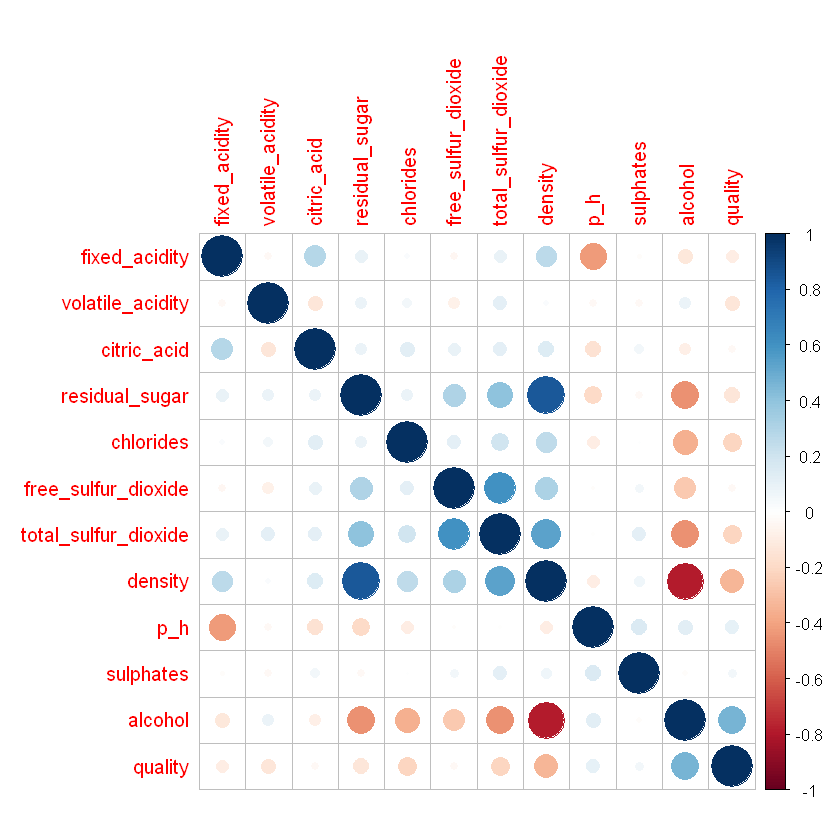

In [875]:
#Correlation Heatmap of Variables
corrplot(cor(df[1:12]))

as heatmap suggestions alcohol jas strongest correlation with the wine quality

# Outlier Remove

using data vizializations to detect outliaers

### IQR

In [876]:
z_score = function(x) {
  return((x - mean(x)) / sd(x))
}

In [877]:
#find Q1, Q3, and interquartile range for values in column A
Q1 <- quantile(df$total_sulfur_dioxide, .25)
Q3 <- quantile(df$total_sulfur_dioxide, .75)
IQR <- IQR(df$total_sulfur_dioxide)

#only keep rows in dataframe that have values within 1.5*IQR of Q1 and Q3
no_outliers_IQR <- subset(df, df$total_sulfur_dioxide> (Q1 - 1.5*IQR) & df$total_sulfur_dioxide< (Q3 + 1.5*IQR))

#view row and column count of new data frame
dim(no_outliers_IQR)

[1] 4695   13

In [878]:
# boxplot(no_outliers_IQR$total_sulfur_dioxide)

### Z score

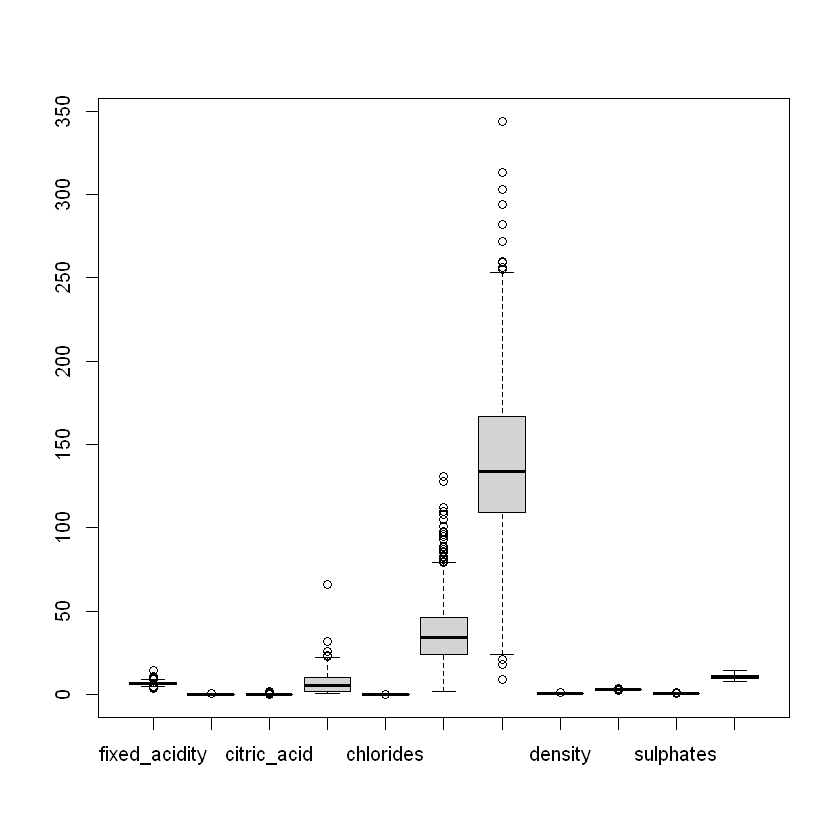

In [879]:
boxplot(df[1:11])

In [880]:
z_score = function(x) {
  return((x - mean(x)) / sd(x))
}

In [881]:
dfNorm <- as.data.frame(lapply(df[1:11], z_score))
dfNorm$index <- 1:nrow(dfNorm)
head(dfNorm)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,p_h,sulphates,alcohol,index
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,1.5238976,-0.04648274,0.6271255,-0.9831716,-0.58570079,-1.5272358,-1.8230268,-1.0701698,-1.31955843,0.61051063,1.1935810,1
2,2.1293483,-0.46690270,0.5433238,-0.4429502,-0.49277626,-1.1554516,-0.7152461,0.2268701,-0.32155169,0.34731453,-0.6685289,2
3,1.2817173,-0.99242766,0.2919184,-1.0322826,-0.26046491,-1.2174157,-1.5340406,-0.6710806,-0.05541657,1.22463485,0.2220454,3
4,1.7660778,1.53009213,2.3869628,2.5135339,-0.26046491,0.3316852,0.8019318,2.0560288,-1.38609221,1.57556298,-0.6685289,4
5,-0.4135447,0.37393723,-1.6355225,0.2053154,-0.07461584,-0.1020631,-0.1372736,0.4929295,0.21071856,0.08411844,-0.8304515,5
6,0.9184469,4.15771691,-1.6355225,-0.9733494,1.31925222,-0.6597394,0.7056030,-0.1057043,-0.92035573,0.17185047,-0.9923741,6


In [882]:
summary(dfNorm[1:11])

 fixed_acidity      volatile_acidity   citric_acid      residual_sugar   
 Min.   :-3.68298   Min.   :-2.0435   Min.   :-2.8087   Min.   :-1.1501  
 1st Qu.:-0.65573   1st Qu.:-0.6771   1st Qu.:-0.5461   1st Qu.:-0.9341  
 Median :-0.05027   Median :-0.1516   Median :-0.1271   Median :-0.2269  
 Mean   : 0.00000   Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.: 0.55518   3rd Qu.: 0.4790   3rd Qu.: 0.4595   3rd Qu.: 0.6964  
 Max.   : 8.91040   Max.   : 7.2583   Max.   :11.1023   Max.   :11.6580  
   chlorides       free_sulfur_dioxide total_sulfur_dioxide    density       
 Min.   :-1.7008   Min.   :-2.0849     Min.   :-3.1235      Min.   :-2.2974  
 1st Qu.:-0.4463   1st Qu.:-0.7217     1st Qu.:-0.7152      1st Qu.:-0.7709  
 Median :-0.1211   Median :-0.1021     Median :-0.1132      Median :-0.1057  
 Mean   : 0.0000   Mean   : 0.0000     Mean   : 0.0000      Mean   : 0.0000  
 3rd Qu.: 0.2042   3rd Qu.: 0.6415     3rd Qu.: 0.6815      3rd Qu.: 0.6925  
 Max.   :13.95

In [883]:
#only keep rows in dataframe with all z-scores less than absolute value of 3 
no_outliers <- dfNorm[!rowSums(dfNorm[1:11]>3),]

In [884]:
head(no_outliers)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,p_h,sulphates,alcohol,index
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,1.5238976,-0.04648274,0.6271255,-0.9831716,-0.58570079,-1.5272358,-1.8230268,-1.0701698,-1.31955843,0.61051063,1.1935810,1
2,2.1293483,-0.46690270,0.5433238,-0.4429502,-0.49277626,-1.1554516,-0.7152461,0.2268701,-0.32155169,0.34731453,-0.6685289,2
3,1.2817173,-0.99242766,0.2919184,-1.0322826,-0.26046491,-1.2174157,-1.5340406,-0.6710806,-0.05541657,1.22463485,0.2220454,3
4,1.7660778,1.53009213,2.3869628,2.5135339,-0.26046491,0.3316852,0.8019318,2.0560288,-1.38609221,1.57556298,-0.6685289,4
5,-0.4135447,0.37393723,-1.6355225,0.2053154,-0.07461584,-0.1020631,-0.1372736,0.4929295,0.21071856,0.08411844,-0.8304515,5
7,-1.2611757,-0.04648274,-1.1327118,1.6688241,-0.07461584,-0.8456315,0.9705071,0.7257315,1.20872529,-1.05639797,-0.2637224,7


In [885]:
# merge normalized one ane orginal quality
# merge two data frames by ID
df_final <- merge(no_outliers,df[12:13],by="index")

In [886]:
head(df_final)

,index,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,p_h,sulphates,alcohol,quality
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1.5238976,-0.04648274,0.6271255,-0.9831716,-0.58570079,-1.5272358,-1.8230268,-1.0701698,-1.31955843,0.61051063,1.1935810,5
2,2,2.1293483,-0.46690270,0.5433238,-0.4429502,-0.49277626,-1.1554516,-0.7152461,0.2268701,-0.32155169,0.34731453,-0.6685289,5
3,3,1.2817173,-0.99242766,0.2919184,-1.0322826,-0.26046491,-1.2174157,-1.5340406,-0.6710806,-0.05541657,1.22463485,0.2220454,5
4,4,1.7660778,1.53009213,2.3869628,2.5135339,-0.26046491,0.3316852,0.8019318,2.0560288,-1.38609221,1.57556298,-0.6685289,5
5,5,-0.4135447,0.37393723,-1.6355225,0.2053154,-0.07461584,-0.1020631,-0.1372736,0.4929295,0.21071856,0.08411844,-0.8304515,5
6,7,-1.2611757,-0.04648274,-1.1327118,1.6688241,-0.07461584,-0.8456315,0.9705071,0.7257315,1.20872529,-1.05639797,-0.2637224,5


In [887]:
summary(df_final[2:12])

 fixed_acidity      volatile_acidity    citric_acid       residual_sugar      
 Min.   :-3.56189   Min.   :-2.04348   Min.   :-2.80875   Min.   :-1.1501491  
 1st Qu.:-0.65573   1st Qu.:-0.67711   1st Qu.:-0.54610   1st Qu.:-0.9144161  
 Median :-0.05027   Median :-0.15159   Median :-0.21089   Median :-0.2072173  
 Mean   :-0.01286   Mean   :-0.05957   Mean   :-0.06593   Mean   : 0.0007457  
 3rd Qu.: 0.55518   3rd Qu.: 0.47904   3rd Qu.: 0.37572   3rd Qu.: 0.6964257  
 Max.   : 2.97698   Max.   : 2.94901   Max.   : 2.97358   Max.   : 2.8180223  
   chlorides       free_sulfur_dioxide total_sulfur_dioxide    density        
 Min.   :-1.5614   Min.   :-2.08491    Min.   :-2.83448     Min.   :-2.29737  
 1st Qu.:-0.4928   1st Qu.:-0.72170    1st Qu.:-0.73933     1st Qu.:-0.78748  
 Median :-0.1675   Median :-0.10206    Median :-0.11319     Median :-0.13231  
 Mean   :-0.1192   Mean   :-0.02871    Mean   :-0.01793     Mean   :-0.02102  
 3rd Qu.: 0.2042   3rd Qu.: 0.57954    3rd Qu.: 0.65

In [888]:
histogram = function(x,title,x_label) {
  # Add a Normal Curve (Thanks to Peter Dalgaard)
  x <- x
  h<-hist(x, breaks=10, col="red", xlab=x_label,
    main=title)
  xfit<-seq(min(x),max(x),length=40)
  yfit<-dnorm(xfit,mean=mean(x),sd=sd(x))
  yfit <- yfit*diff(h$mids[1:2])*length(x)
  lines(xfit, yfit, col="blue", lwd=2)
}

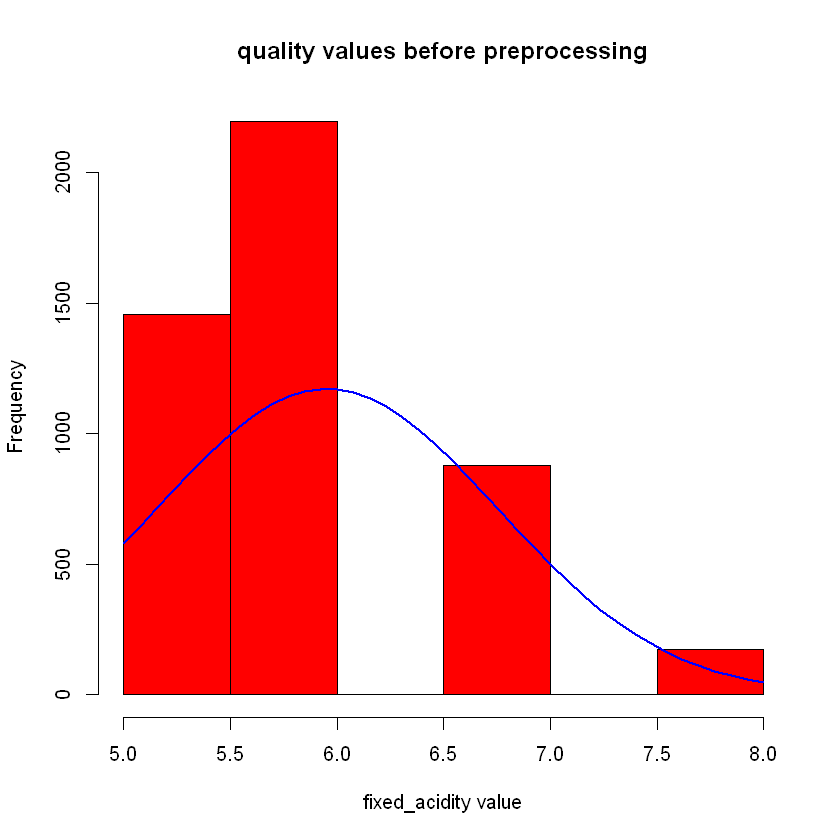

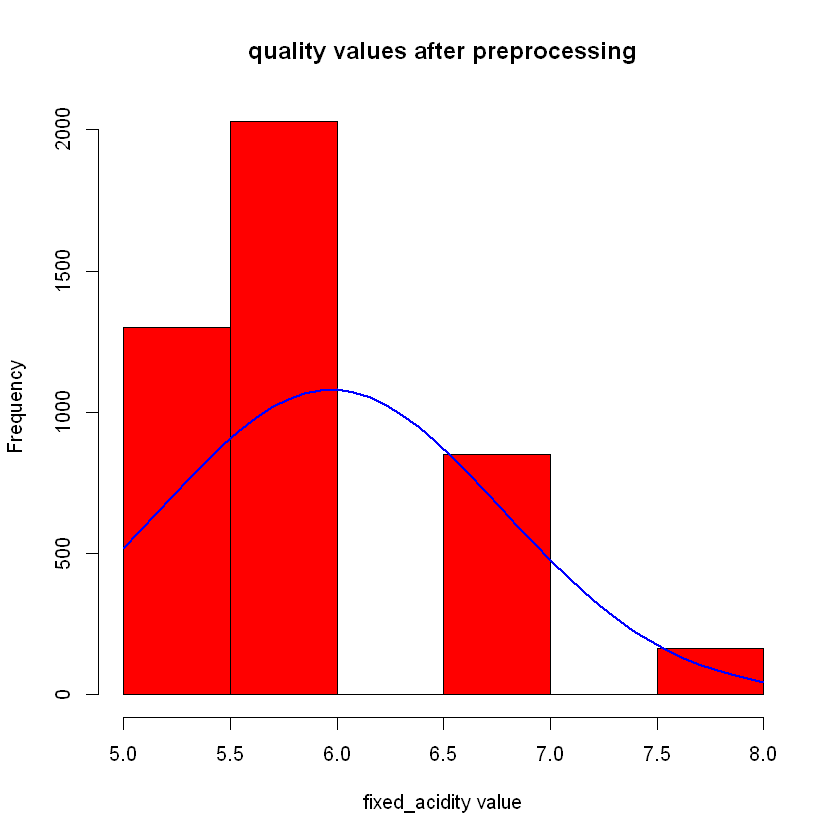

In [889]:
# histogram(df$fixed_acidity,"fixed_acidity values before preprocessing","fixed_acidity value")
# histogram(df_final$fixed_acidity,"fixed_acidity values after preprocessing","fixed_acidity value")
histogram(df$quality,"quality values before preprocessing","fixed_acidity value")
histogram(df_final$quality,"quality values after preprocessing","fixed_acidity value")

Define the number of cluster centres (via manual & automated tools). The
automated tools should include NBclust, Elbow and one from Gap statistics or silhouette methods

## Malual Methods - Define Cluster Centers

In [890]:
head(df_final)

,index,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,p_h,sulphates,alcohol,quality
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1.5238976,-0.04648274,0.6271255,-0.9831716,-0.58570079,-1.5272358,-1.8230268,-1.0701698,-1.31955843,0.61051063,1.1935810,5
2,2,2.1293483,-0.46690270,0.5433238,-0.4429502,-0.49277626,-1.1554516,-0.7152461,0.2268701,-0.32155169,0.34731453,-0.6685289,5
3,3,1.2817173,-0.99242766,0.2919184,-1.0322826,-0.26046491,-1.2174157,-1.5340406,-0.6710806,-0.05541657,1.22463485,0.2220454,5
4,4,1.7660778,1.53009213,2.3869628,2.5135339,-0.26046491,0.3316852,0.8019318,2.0560288,-1.38609221,1.57556298,-0.6685289,5
5,5,-0.4135447,0.37393723,-1.6355225,0.2053154,-0.07461584,-0.1020631,-0.1372736,0.4929295,0.21071856,0.08411844,-0.8304515,5
6,7,-1.2611757,-0.04648274,-1.1327118,1.6688241,-0.07461584,-0.8456315,0.9705071,0.7257315,1.20872529,-1.05639797,-0.2637224,5


# Automatic Methods

#### NbClust

In [891]:
# see the datasrt types
str(df_final)

'data.frame':	4342 obs. of  13 variables:
 $ index               : int  1 2 3 4 5 7 8 9 10 11 ...
 $ fixed_acidity       : num  1.524 2.129 1.282 1.766 -0.414 ...
 $ volatile_acidity    : num  -0.0465 -0.4669 -0.9924 1.5301 0.3739 ...
 $ citric_acid         : num  0.627 0.543 0.292 2.387 -1.636 ...
 $ residual_sugar      : num  -0.983 -0.443 -1.032 2.514 0.205 ...
 $ chlorides           : num  -0.5857 -0.4928 -0.2605 -0.2605 -0.0746 ...
 $ free_sulfur_dioxide : num  -1.527 -1.155 -1.217 0.332 -0.102 ...
 $ total_sulfur_dioxide: num  -1.823 -0.715 -1.534 0.802 -0.137 ...
 $ density             : num  -1.07 0.227 -0.671 2.056 0.493 ...
 $ p_h                 : num  -1.3196 -0.3216 -0.0554 -1.3861 0.2107 ...
 $ sulphates           : num  0.6105 0.3473 1.2246 1.5756 0.0841 ...
 $ alcohol             : num  1.194 -0.669 0.222 -0.669 -0.83 ...
 $ quality             : num  5 5 5 5 5 5 5 5 5 5 ...


In [892]:
df_nb <- df_final[2:12]

In [893]:
#setting seed point
set.seed(26)

In [894]:
# #euclidient distance
# no_of_clusters_eud = NbClust(df_nb,distance="euclidean", min.nc=2,max.nc=10,method="kmeans",index="all")

In [895]:
# #manhatten
# no_of_clusters_man = NbClust(df_nb,distance="manhattan", min.nc=2,max.nc=15,method="kmeans",index="all")

In [896]:
# #maximum
# no_of_clusters_maximum = NbClust(df_nb,distance="maximum", min.nc=2,max.nc=15,method="kmeans",index="all")

#### Elbow

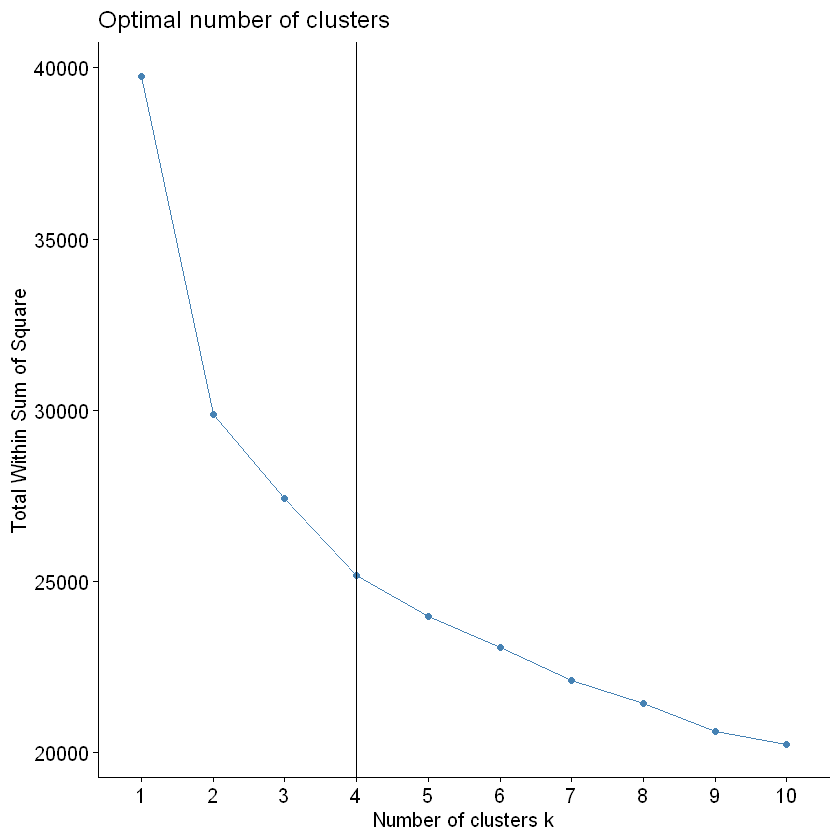

In [897]:
fviz_nbclust(df_final[2:12],kmeans,method="wss")+geom_vline(xintercept=4,linetype=1)

In [898]:
k = 1:10

In [899]:

set.seed(25)	
WSS = sapply(k, function(k) {kmeans(df_final[2:12], centers=k)$tot.withinss})


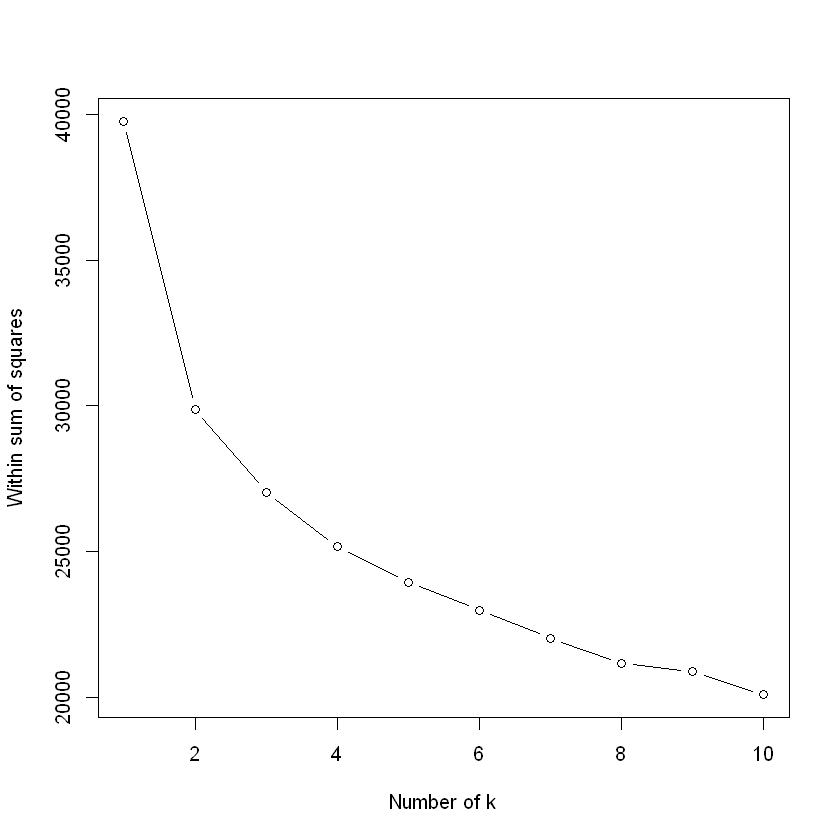

In [900]:
# You can then use a line plot to plot the within sum of squares with a different number of k
plot(k, WSS, type="b", xlab= "Number of k", ylab="Within sum of squares")


#### Silhoutte

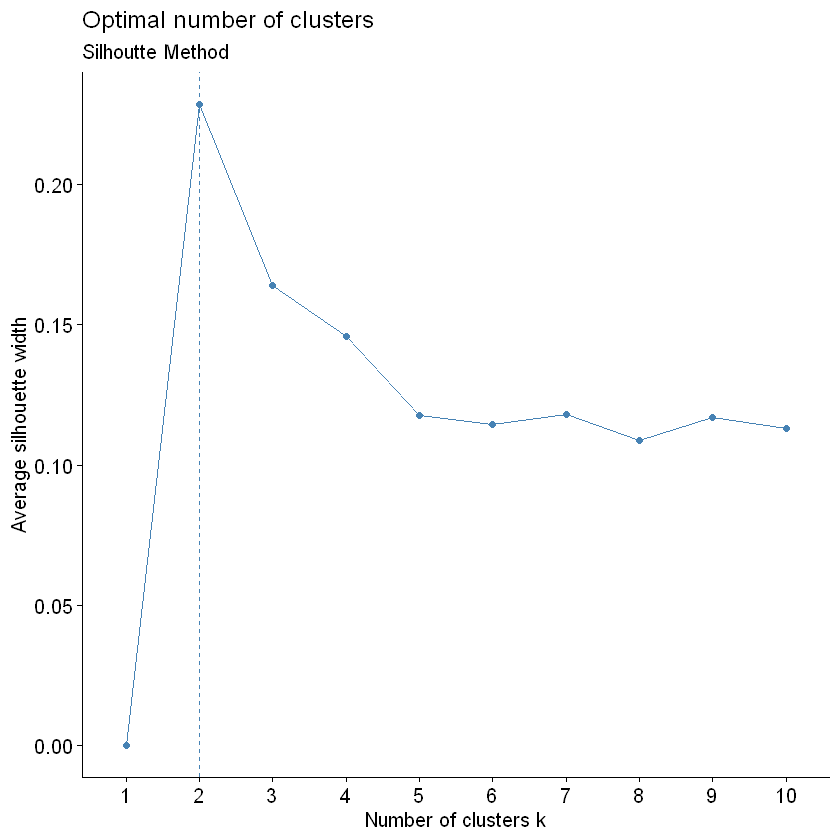

In [901]:
fviz_nbclust(df_final[2:12], kmeans, method = "silhouette") + 
labs(subtitle = "Silhoutte Method")

# k-means clustering

In [902]:
head(df_final)

,index,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,p_h,sulphates,alcohol,quality
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1.5238976,-0.04648274,0.6271255,-0.9831716,-0.58570079,-1.5272358,-1.8230268,-1.0701698,-1.31955843,0.61051063,1.1935810,5
2,2,2.1293483,-0.46690270,0.5433238,-0.4429502,-0.49277626,-1.1554516,-0.7152461,0.2268701,-0.32155169,0.34731453,-0.6685289,5
3,3,1.2817173,-0.99242766,0.2919184,-1.0322826,-0.26046491,-1.2174157,-1.5340406,-0.6710806,-0.05541657,1.22463485,0.2220454,5
4,4,1.7660778,1.53009213,2.3869628,2.5135339,-0.26046491,0.3316852,0.8019318,2.0560288,-1.38609221,1.57556298,-0.6685289,5
5,5,-0.4135447,0.37393723,-1.6355225,0.2053154,-0.07461584,-0.1020631,-0.1372736,0.4929295,0.21071856,0.08411844,-0.8304515,5
6,7,-1.2611757,-0.04648274,-1.1327118,1.6688241,-0.07461584,-0.8456315,0.9705071,0.7257315,1.20872529,-1.05639797,-0.2637224,5


#### k=2

In [903]:
x=df_final[2:12]
y=df_final$quality

In [904]:
kc_2 <- kmeans(x,centers=2)

In [905]:
kc_2

K-means clustering with 2 clusters of sizes 1681, 2661

Cluster means:
  fixed_acidity volatile_acidity citric_acid residual_sugar  chlorides
1     0.1496217      -0.01618924  0.09644741      0.9108840  0.1401720
2    -0.1155064      -0.08696850 -0.16850322     -0.5742046 -0.2830937
  free_sulfur_dioxide total_sulfur_dioxide    density        p_h   sulphates
1           0.5745835            0.7689961  0.9685464 -0.1705149  0.04701108
2          -0.4098224           -0.5150499 -0.6461456  0.1060547 -0.09263144
     alcohol
1 -0.7874905
2  0.5318484

Clustering vector:
   [1] 2 2 2 1 1 1 2 2 1 1 1 1 2 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1
  [38] 2 1 1 2 2 1 1 1 1 1 2 1 2 1 2 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 1
  [75] 1 1 2 1 1 1 1 2 1 2 1 1 2 1 1 1 2 1 1 1 1 1 1 2 2 2 2 2 1 2 2 2 1 2 2 1 2
 [112] 1 2 1 1 2 1 2 2 2 2 1 1 2 1 1 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2
 [149] 1 2 2 2 2 1 1 2 1 1 1 2 1 1 1 1 1 2 1 1 2 2 1 2 2 1 1 1 1 1 1 1 1 1 2 2 1
 [186] 1 1 1 1 1 1 1 

In [906]:
str(kc_2)

List of 9
 $ cluster     : int [1:4342] 2 2 2 1 1 1 2 2 1 1 ...
 $ centers     : num [1:2, 1:11] 0.1496 -0.1155 -0.0162 -0.087 0.0964 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:2] "1" "2"
  .. ..$ : chr [1:11] "fixed_acidity" "volatile_acidity" "citric_acid" "residual_sugar" ...
 $ totss       : num 39754
 $ withinss    : num [1:2] 11131 18741
 $ tot.withinss: num 29872
 $ betweenss   : num 9882
 $ size        : int [1:2] 1681 2661
 $ iter        : int 1
 $ ifault      : int 0
 - attr(*, "class")= chr "kmeans"


In [929]:
class_column = df_final$quality

[1] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
  [38] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
  [75] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 [112] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 [149] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 [186] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 [223] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 [260] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 [297] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 [334] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 [371] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 [408] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 [445] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 [482] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 [519] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 [556] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 [593] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 [630] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 [667] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 [704] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 [741] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 [778] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 [815] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 [852] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 [889] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 [926] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 [963] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
[1000] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
[1037] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
[1074] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
[1111] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
[1148] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
[1185] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
[1222] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
[1259] 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
[1296] 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
[1333] 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
[1370] 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
[1407] 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
[1444] 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
[1481] 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
[1518] 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
[1555] 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
[1592] 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
[1629] 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
[1666] 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
[1703] 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
[1740] 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
[1777] 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
[1814] 6 6 6 6 6 6 6 6 6 6 6 6 6 6

In [907]:
table(y,kc_2$cluster)

   
y      1    2
  5  728  571
  6  774 1256
  7  153  698
  8   26  136

In [908]:
# implement the metrix
confusionMatrix(

 factor(kc_2$cluster, levels = 1:8),

 factor(df_final$quality,levels=1:8)
)

Confusion Matrix and Statistics

          Reference
Prediction    1    2    3    4    5    6    7    8
         1    0    0    0    0  728  774  153   26
         2    0    0    0    0  571 1256  698  136
         3    0    0    0    0    0    0    0    0
         4    0    0    0    0    0    0    0    0
         5    0    0    0    0    0    0    0    0
         6    0    0    0    0    0    0    0    0
         7    0    0    0    0    0    0    0    0
         8    0    0    0    0    0    0    0    0

Overall Statistics
                                    
               Accuracy : 0         
                 95% CI : (0, 8e-04)
    No Information Rate : 0.4675    
    P-Value [Acc > NIR] : 1         
                                    
                  Kappa : 0         
                                    
 Mcnemar's Test P-Value : NA        

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4 Class: 5 Class: 6
Sensitivity                NA       N

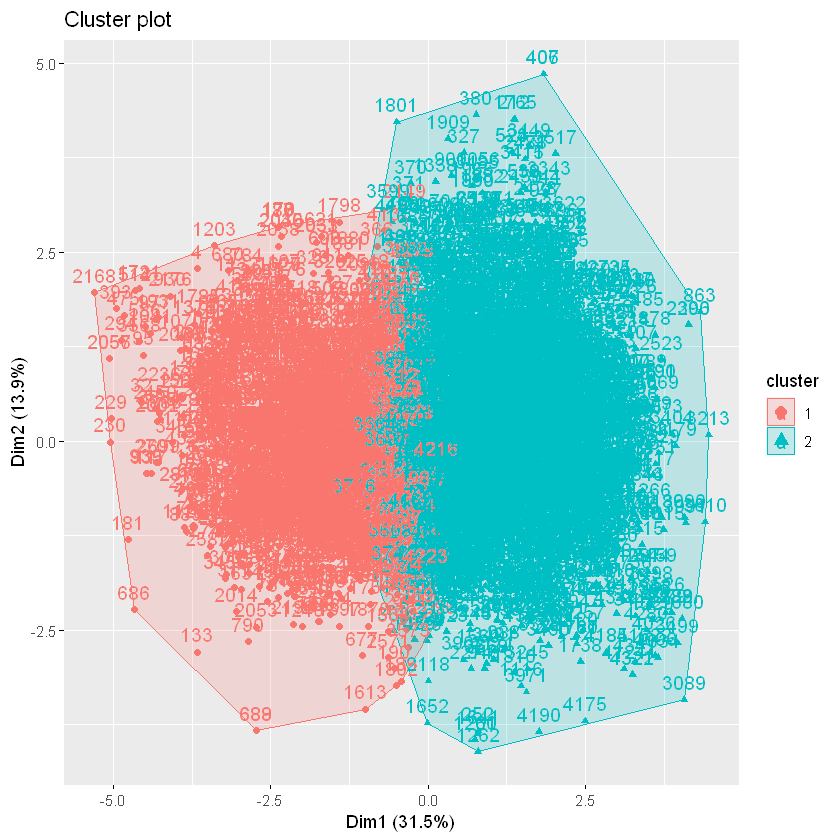

In [909]:
fviz_cluster(kc_2,data=x)

### k=3

In [910]:
kc_3 <- kmeans(x,centers=3)

In [911]:
kc_3

K-means clustering with 3 clusters of sizes 1588, 1422, 1332

Cluster means:
  fixed_acidity volatile_acidity citric_acid residual_sugar  chlorides
1     0.1290734      -0.01961081  0.10631965      0.9627448  0.1538919
2    -0.7515667      -0.13126152 -0.35215304     -0.6079937 -0.2791544
3     0.6065398      -0.03066175  0.03428458     -0.4962718 -0.2741036
  free_sulfur_dioxide total_sulfur_dioxide    density        p_h   sulphates
1           0.5992075            0.7757037  1.0102878 -0.1863473  0.05301445
2          -0.2321570           -0.3852846 -0.6650372  0.7714832  0.12280197
3          -0.5601177           -0.5719282 -0.5630039 -0.6047698 -0.32002852
     alcohol
1 -0.8287690
2  0.4993900
3  0.5235958

Clustering vector:
   [1] 3 3 3 1 1 1 3 2 1 1 1 2 3 2 1 3 1 3 1 3 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1
  [38] 2 1 1 3 2 1 1 1 1 1 2 1 3 1 2 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 3
  [75] 1 1 3 3 1 1 1 3 1 2 1 1 3 1 1 1 3 1 1 1 1 1 2 3 3 3 3 3 1 2 2 2 1 3 3 1 3
 [112] 1 3 1 1 2

In [912]:
str(kc_3)

List of 9
 $ cluster     : int [1:4342] 3 3 3 1 1 1 3 2 1 1 ...
 $ centers     : num [1:3, 1:11] 0.1291 -0.7516 0.6065 -0.0196 -0.1313 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:3] "1" "2" "3"
  .. ..$ : chr [1:11] "fixed_acidity" "volatile_acidity" "citric_acid" "residual_sugar" ...
 $ totss       : num 39754
 $ withinss    : num [1:3] 10162 8815 8072
 $ tot.withinss: num 27049
 $ betweenss   : num 12705
 $ size        : int [1:3] 1588 1422 1332
 $ iter        : int 4
 $ ifault      : int 0
 - attr(*, "class")= chr "kmeans"


In [913]:
table(y,kc_3$cluster)

   
y     1   2   3
  5 691 254 354
  6 730 669 631
  7 142 420 289
  8  25  79  58

In [914]:
# implement the metrix
confusionMatrix(

 factor(kc_3$cluster, levels = 1:8),

 factor(df_final$quality,levels=1:8)
)

Confusion Matrix and Statistics

          Reference
Prediction   1   2   3   4   5   6   7   8
         1   0   0   0   0 691 730 142  25
         2   0   0   0   0 254 669 420  79
         3   0   0   0   0 354 631 289  58
         4   0   0   0   0   0   0   0   0
         5   0   0   0   0   0   0   0   0
         6   0   0   0   0   0   0   0   0
         7   0   0   0   0   0   0   0   0
         8   0   0   0   0   0   0   0   0

Overall Statistics
                                    
               Accuracy : 0         
                 95% CI : (0, 8e-04)
    No Information Rate : 0.4675    
    P-Value [Acc > NIR] : 1         
                                    
                  Kappa : 0         
                                    
 Mcnemar's Test P-Value : NA        

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4 Class: 5 Class: 6
Sensitivity                NA       NA       NA       NA   0.0000   0.0000
Specificity            0.6343   0.

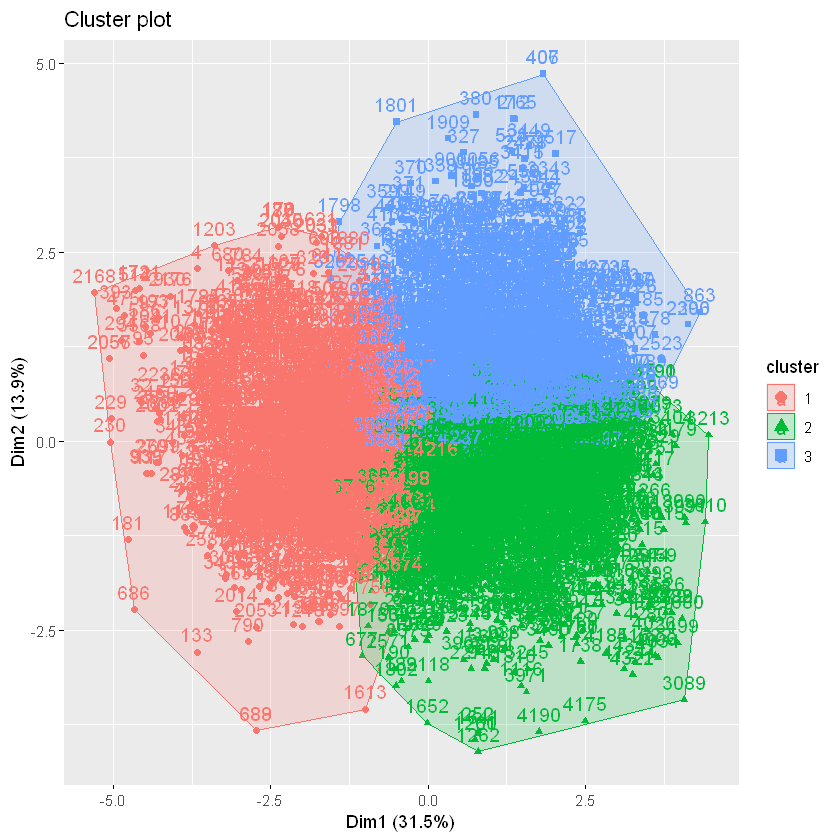

In [915]:
fviz_cluster(kc_3,data=x)

## k=4

In [916]:
kc_4 <- kmeans(x,centers=4)

In [917]:
kc_4

K-means clustering with 4 clusters of sizes 1030, 1044, 1385, 883

Cluster means:
  fixed_acidity volatile_acidity citric_acid residual_sugar   chlorides
1     0.8293339      -0.21036489   0.1226876     -0.4679158 -0.22009236
2    -0.5005927      -0.35470010  -0.3215042     -0.4902831 -0.04426405
3     0.1446065       0.02348607   0.1400466      1.0921578  0.15964122
4    -0.6655987       0.33501386  -0.3068420     -0.5839095 -0.52760980
  free_sulfur_dioxide total_sulfur_dioxide    density        p_h    sulphates
1         -0.55680687          -0.52317314 -0.3957317 -0.6672044 -0.279501018
2         -0.06443355           0.01161385 -0.1866211  0.7918058  0.326558010
3          0.64855180           0.82004125  1.0951099 -0.2759148  0.005571351
4         -0.43276012          -0.77789256 -1.1387976  0.2698681 -0.258463717
     alcohol
1  0.3029150
2 -0.1472720
3 -0.8773233
4  1.3004749

Clustering vector:
   [1] 1 1 1 3 2 3 1 2 3 3 3 2 4 2 2 1 3 1 1 2 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3
  

In [918]:
str(kc_4)

List of 9
 $ cluster     : int [1:4342] 1 1 1 3 2 3 1 2 3 3 ...
 $ centers     : num [1:4, 1:11] 0.829 -0.501 0.145 -0.666 -0.21 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:4] "1" "2" "3" "4"
  .. ..$ : chr [1:11] "fixed_acidity" "volatile_acidity" "citric_acid" "residual_sugar" ...
 $ totss       : num 39754
 $ withinss    : num [1:4] 5918 6130 8465 4655
 $ tot.withinss: num 25169
 $ betweenss   : num 14585
 $ size        : int [1:4] 1030 1044 1385 883
 $ iter        : int 5
 $ ifault      : int 0
 - attr(*, "class")= chr "kmeans"


In [919]:
table(y,kc_4$cluster)

   
y     1   2   3   4
  5 317 277 628  77
  6 496 541 612 381
  7 177 194 126 354
  8  40  32  19  71

In [924]:
# implement the metrix
confusionMatrix(

 factor(kc_4$cluster, levels = 1:8),

 factor(df_final$quality,levels=1:8)
)

Confusion Matrix and Statistics

          Reference
Prediction   1   2   3   4   5   6   7   8
         1   0   0   0   0 317 496 177  40
         2   0   0   0   0 277 541 194  32
         3   0   0   0   0 628 612 126  19
         4   0   0   0   0  77 381 354  71
         5   0   0   0   0   0   0   0   0
         6   0   0   0   0   0   0   0   0
         7   0   0   0   0   0   0   0   0
         8   0   0   0   0   0   0   0   0

Overall Statistics
                                    
               Accuracy : 0         
                 95% CI : (0, 8e-04)
    No Information Rate : 0.4675    
    P-Value [Acc > NIR] : 1         
                                    
                  Kappa : 0         
                                    
 Mcnemar's Test P-Value : NA        

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4 Class: 5 Class: 6
Sensitivity                NA       NA       NA       NA   0.0000   0.0000
Specificity            0.7628   0.

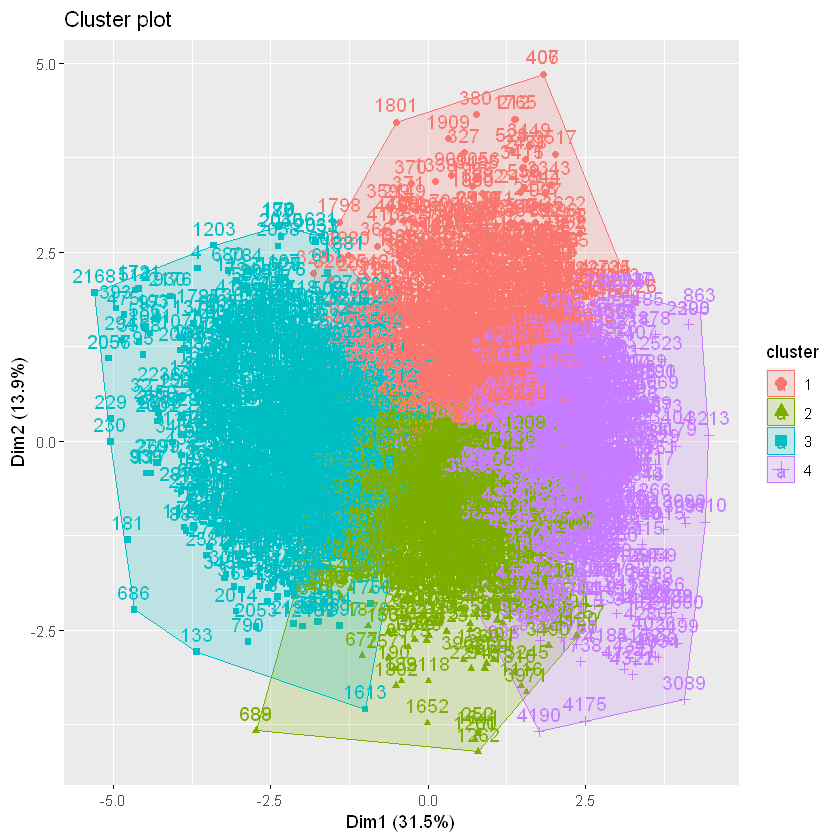

In [921]:
fviz_cluster(kc_4,data=x)

## PCA

In [932]:
head(df_final)

,index,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,p_h,sulphates,alcohol,quality
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1.5238976,-0.04648274,0.6271255,-0.9831716,-0.58570079,-1.5272358,-1.8230268,-1.0701698,-1.31955843,0.61051063,1.1935810,5
2,2,2.1293483,-0.46690270,0.5433238,-0.4429502,-0.49277626,-1.1554516,-0.7152461,0.2268701,-0.32155169,0.34731453,-0.6685289,5
3,3,1.2817173,-0.99242766,0.2919184,-1.0322826,-0.26046491,-1.2174157,-1.5340406,-0.6710806,-0.05541657,1.22463485,0.2220454,5
4,4,1.7660778,1.53009213,2.3869628,2.5135339,-0.26046491,0.3316852,0.8019318,2.0560288,-1.38609221,1.57556298,-0.6685289,5
5,5,-0.4135447,0.37393723,-1.6355225,0.2053154,-0.07461584,-0.1020631,-0.1372736,0.4929295,0.21071856,0.08411844,-0.8304515,5
6,7,-1.2611757,-0.04648274,-1.1327118,1.6688241,-0.07461584,-0.8456315,0.9705071,0.7257315,1.20872529,-1.05639797,-0.2637224,5


In [937]:
principle_components <- prcomp(df_final[2:12])

In [938]:
principle_components

Standard deviations (1, .., p=11):
 [1] 1.7637111 1.1597870 0.9848076 0.9445540 0.8866711 0.7602305 0.7422495
 [8] 0.6783070 0.5146607 0.4335380 0.1092516

Rotation (n x k) = (11 x 11):
                              PC1         PC2         PC3         PC4
fixed_acidity        -0.137581852 -0.59801192  0.32565474  0.04710833
volatile_acidity      0.003614621  0.03454142 -0.37313686  0.48562984
citric_acid          -0.096724297 -0.23355876  0.44578417  0.05255540
residual_sugar       -0.441145600 -0.04157095 -0.30318924 -0.05783970
chlorides            -0.145855652  0.01309497 -0.01897213 -0.11293925
free_sulfur_dioxide  -0.305204270  0.24747938  0.20906901  0.50565029
total_sulfur_dioxide -0.416041688  0.23275917  0.15670945  0.42166843
density              -0.518684644 -0.02011572 -0.11437235 -0.25615517
p_h                   0.104149769  0.63234583  0.08438014 -0.24233680
sulphates            -0.055352542  0.26168678  0.60375550 -0.16411479
alcohol               0.454570232 -0.0238867

In [939]:
summary(principle_components)

Importance of components:
                          PC1    PC2    PC3     PC4     PC5     PC6     PC7
Standard deviation     1.7637 1.1598 0.9848 0.94455 0.88667 0.76023 0.74225
Proportion of Variance 0.3397 0.1469 0.1059 0.09742 0.08585 0.06311 0.06016
Cumulative Proportion  0.3397 0.4866 0.5925 0.68989 0.77574 0.83885 0.89901
                           PC8     PC9    PC10   PC11
Standard deviation     0.67831 0.51466 0.43354 0.1093
Proportion of Variance 0.05024 0.02892 0.02052 0.0013
Cumulative Proportion  0.94925 0.97817 0.99870 1.0000

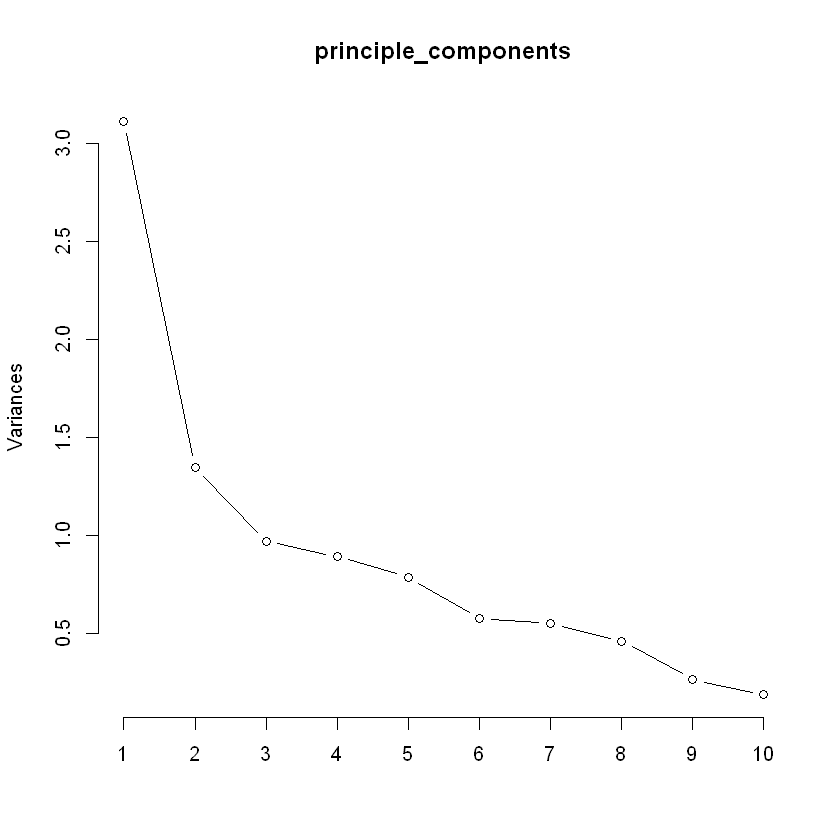

In [941]:
plot(principle_components, type = "l")

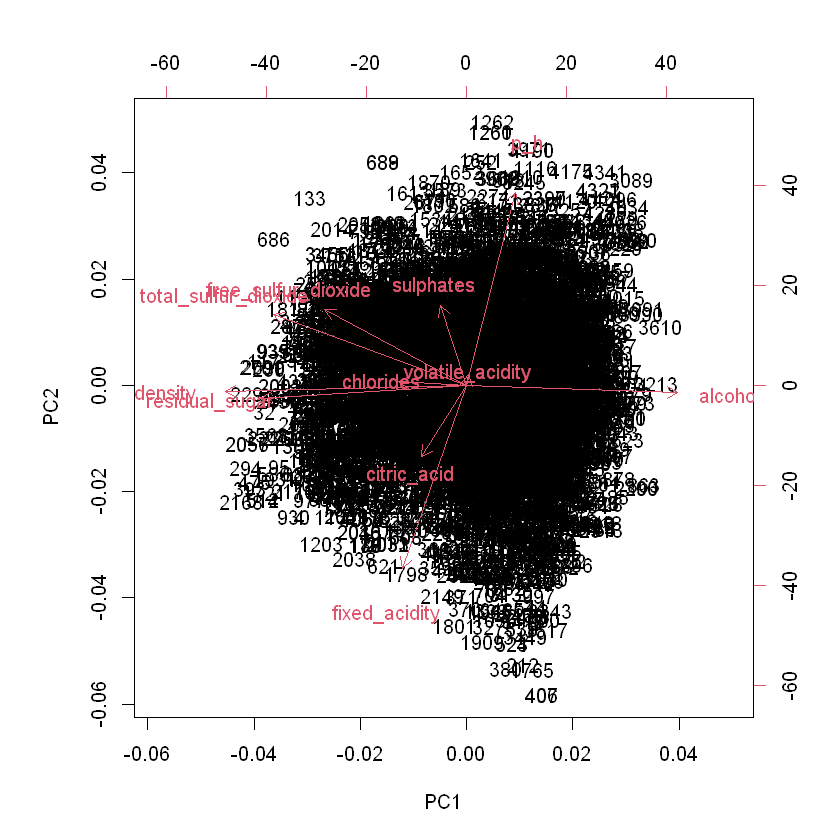

In [942]:
biplot(principle_components)

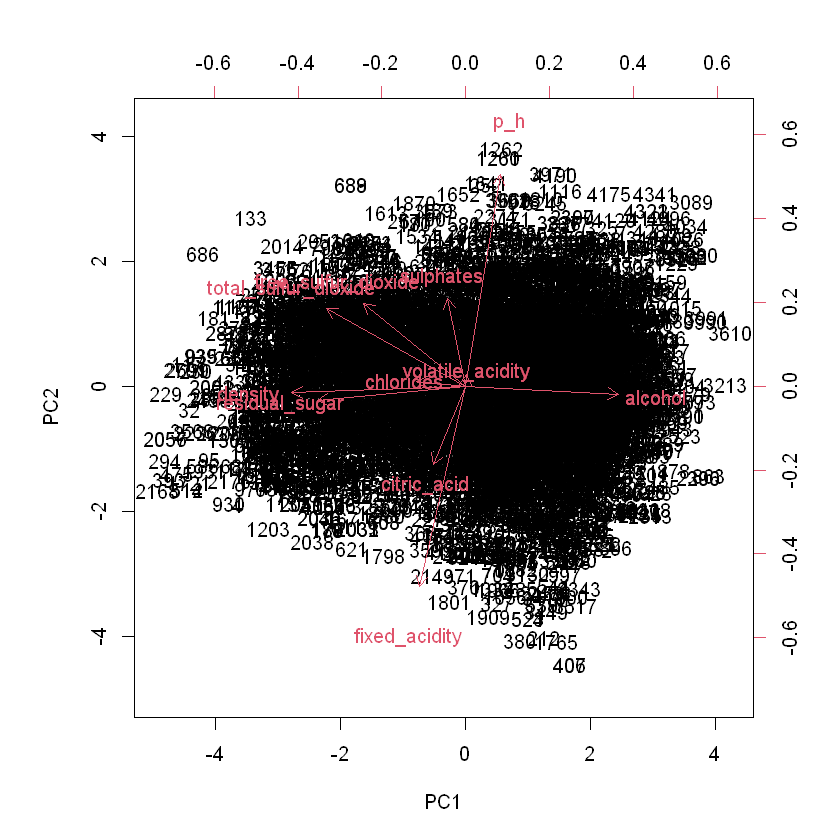

In [943]:
biplot(principle_components, scale = 0)

In [944]:
str(principle_components)

List of 5
 $ sdev    : num [1:11] 1.764 1.16 0.985 0.945 0.887 ...
 $ rotation: num [1:11, 1:11] -0.13758 0.00361 -0.09672 -0.44115 -0.14586 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:11] "fixed_acidity" "volatile_acidity" "citric_acid" "residual_sugar" ...
  .. ..$ : chr [1:11] "PC1" "PC2" "PC3" "PC4" ...
 $ center  : Named num [1:11] -0.012862 -0.059566 -0.065928 0.000746 -0.119227 ...
  ..- attr(*, "names")= chr [1:11] "fixed_acidity" "volatile_acidity" "citric_acid" "residual_sugar" ...
 $ scale   : logi FALSE
 $ x       : num [1:4342, 1:11] 2.3359 0.0323 1.6067 -3.6397 -0.4546 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:11] "PC1" "PC2" "PC3" "PC4" ...
 - attr(*, "class")= chr "prcomp"


In [968]:
df_final_with_pcs <- cbind(df_final, principle_components$x)
head(df_final_with_pcs)

,index,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,p_h,...,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1.5238976,-0.04648274,0.6271255,-0.9831716,-0.58570079,-1.5272358,-1.8230268,-1.0701698,-1.31955843,...,-2.507450,1.037543,-0.3458290,-0.9958955,-0.2267304,0.3549709,0.05716721,0.2180437,0.08122723,-0.02217554
2,2,2.1293483,-0.46690270,0.5433238,-0.4429502,-0.49277626,-1.1554516,-0.7152461,0.2268701,-0.32155169,...,-1.955253,1.024154,-1.1843357,-0.6483172,0.5822436,-0.6051595,0.38769275,0.2500563,0.60554450,0.16234138
3,3,1.2817173,-0.99242766,0.2919184,-1.0322826,-0.26046491,-1.2174157,-1.5340406,-0.6710806,-0.05541657,...,-1.191507,1.612201,-1.4855391,-0.6478954,-0.1857300,-0.2073085,0.27955324,0.3527243,0.05386811,0.15663117
4,4,1.7660778,1.53009213,2.3869628,2.5135339,-0.26046491,0.3316852,0.8019318,2.0560288,-1.38609221,...,-1.886857,1.072986,0.6475778,-2.1442520,0.7347356,2.1111434,-0.09654371,0.2678407,0.31870617,0.05228100
5,5,-0.4135447,0.37393723,-1.6355225,0.2053154,-0.07461584,-0.1020631,-0.1372736,0.4929295,0.21071856,...,0.743327,-1.143859,-0.5370382,-0.5925853,-0.6610490,-0.7228263,0.29321089,0.3476583,0.22213184,-0.04310457
6,7,-1.2611757,-0.04648274,-1.1327118,1.6688241,-0.07461584,-0.8456315,0.9705071,0.7257315,1.20872529,...,1.445659,-2.036778,-0.6370440,0.2145349,0.4920310,0.2976442,0.62233304,-1.3600306,0.03661862,0.27470212


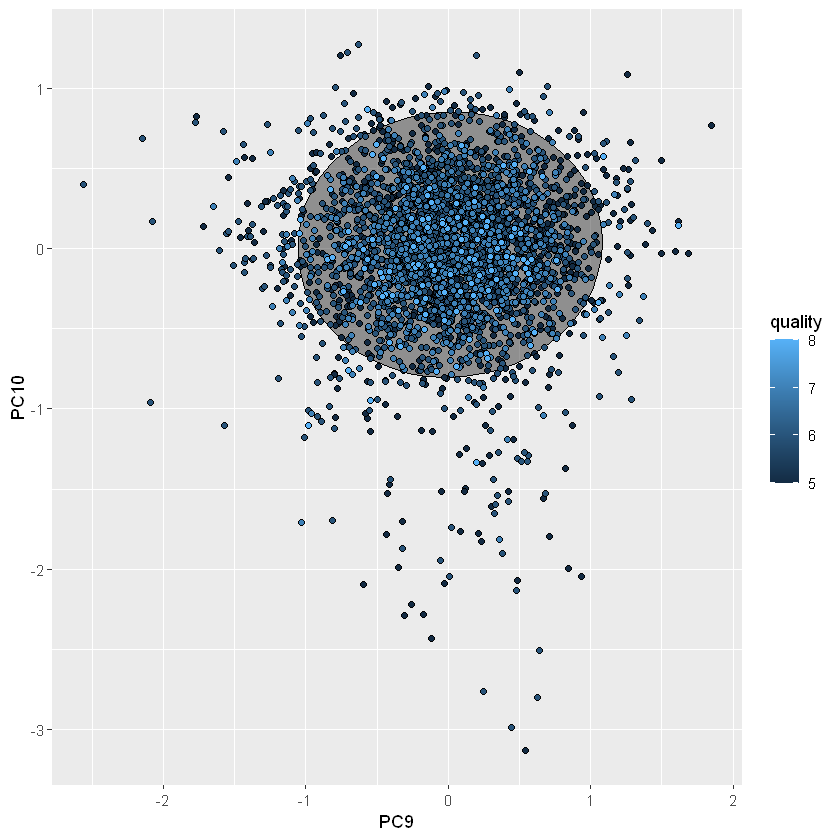

In [975]:
library(ggplot2)

ggplot(df_final_with_pcs, aes(PC9,PC10,PC11,col = quality, fill = quality)) +
  stat_ellipse(geom = "polygon", col = "black", alpha = 0.5) +
  geom_point(shape = 21, col = "black")

#### clustering

In [970]:
x_2 = df_final_with_pcs[22:24]
y_2 = df_final_with_pcs[13]

In [977]:
kcpca <- kmeans(x,4)

In [978]:
kcpca

K-means clustering with 4 clusters of sizes 1030, 1044, 883, 1385

Cluster means:
  fixed_acidity volatile_acidity citric_acid residual_sugar   chlorides
1     0.8293339      -0.21036489   0.1226876     -0.4679158 -0.22009236
2    -0.5005927      -0.35470010  -0.3215042     -0.4902831 -0.04426405
3    -0.6655987       0.33501386  -0.3068420     -0.5839095 -0.52760980
4     0.1446065       0.02348607   0.1400466      1.0921578  0.15964122
  free_sulfur_dioxide total_sulfur_dioxide    density        p_h    sulphates
1         -0.55680687          -0.52317314 -0.3957317 -0.6672044 -0.279501018
2         -0.06443355           0.01161385 -0.1866211  0.7918058  0.326558010
3         -0.43276012          -0.77789256 -1.1387976  0.2698681 -0.258463717
4          0.64855180           0.82004125  1.0951099 -0.2759148  0.005571351
     alcohol
1  0.3029150
2 -0.1472720
3  1.3004749
4 -0.8773233

Clustering vector:
   [1] 1 1 1 4 2 4 1 2 4 4 4 2 3 2 2 1 4 1 1 2 4 4 4 4 4 4 4 4 4 4 2 4 4 4 4 4 4
  

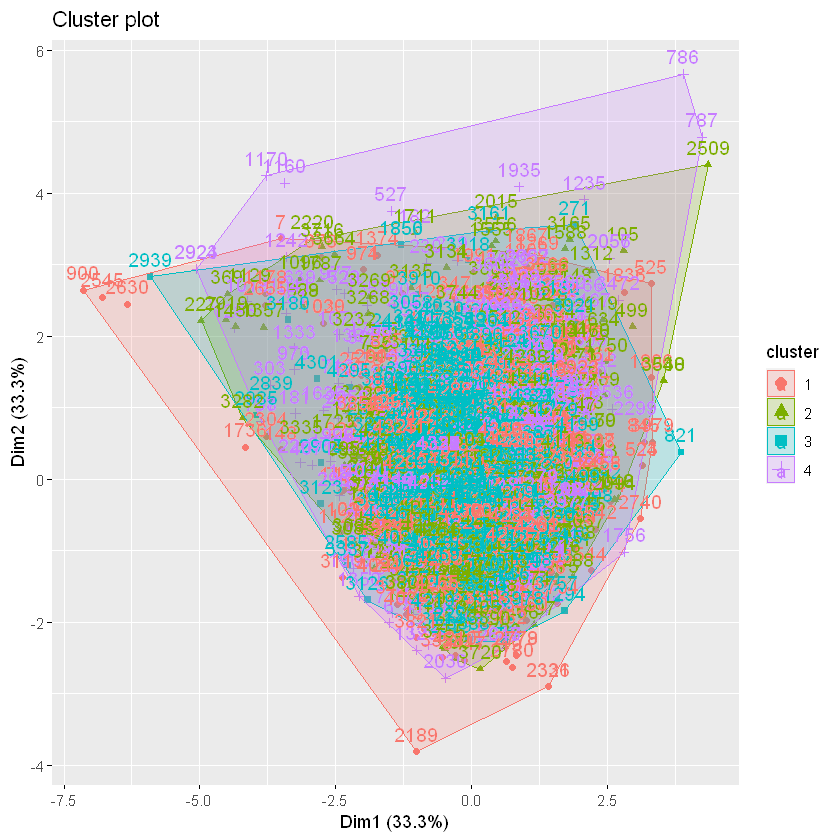

In [981]:
fviz_cluster(kcpca,data=x_2)